# Assignment - Supervised Learning flow

# Part 1(a) Student details:

<pre>
Dror S. 1868
</pre>

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:

<pre>

AI agent name: ChatGPT
    
Goal: Understanding the purpose of different functions and checking their parameters
    
Propmpt1: What's the difference between KFold and GridSearchCV?
    
Propmpt2: Explain what f1 consists of and how it helps the training evaluation
    
Propmpt3: What should I include in my preprocessing for improving the model?

</pre>

## Part 1(c) - Learning Problem and dataset explaination.

<pre>

The problem we are trying to solve is predicting whether a passenger on the Titanic survived or not. Each passenger has information such as their age, gender, ticket class, fare price, number of family members on board, and the port they embarked from. The target column is Survived (1 = survived, 0 = did not survive). Since the data includes both numbers (like age and fare) and categories (like gender and embarkation port), and also has missing values, we need to clean and process it before training a model. By learning from the training data, our model will be able to make predictions on new passengers.

</pre>

## Part 2 - Initial Preparations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import f1_score, classification_report

In [2]:
train_path = 'titanic_train.csv'
test_path  = 'titanic_test.csv'

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)
print('Train shape:', train.shape)
print('Test  shape:', test.shape)

display(train.head())
display(test.head())

Train shape: (712, 8)
Test  shape: (179, 8)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


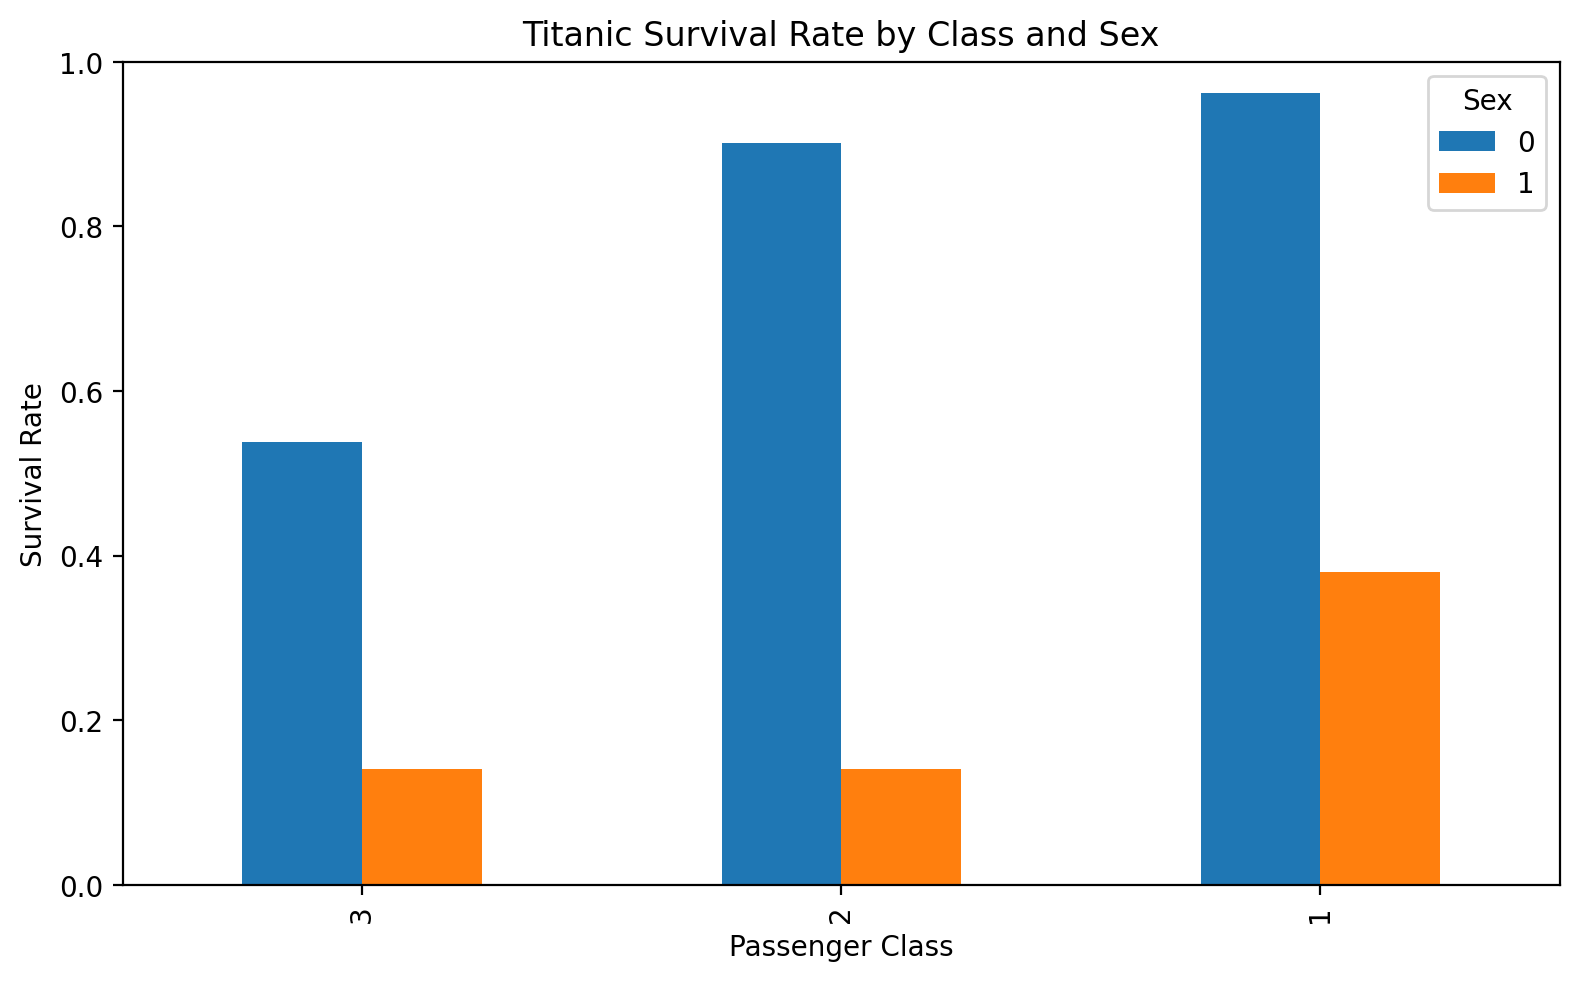

In [3]:
# Survival rate by Pclass and Sex (mean of Survived)
rates = (
    train.groupby(["Pclass", "Sex"])["Survived"]
    .mean()
    .unstack("Sex")
    .sort_index(ascending=False)   # show 3,2,1 top-to-bottom
)

ax = rates.plot(kind="bar", figsize=(8,5))
ax.set_title("Titanic Survival Rate by Class and Sex")
ax.set_xlabel("Passenger Class")
ax.set_ylabel("Survival Rate")
ax.set_ylim(0, 1)
ax.legend(title="Sex")
plt.tight_layout()
plt.show()

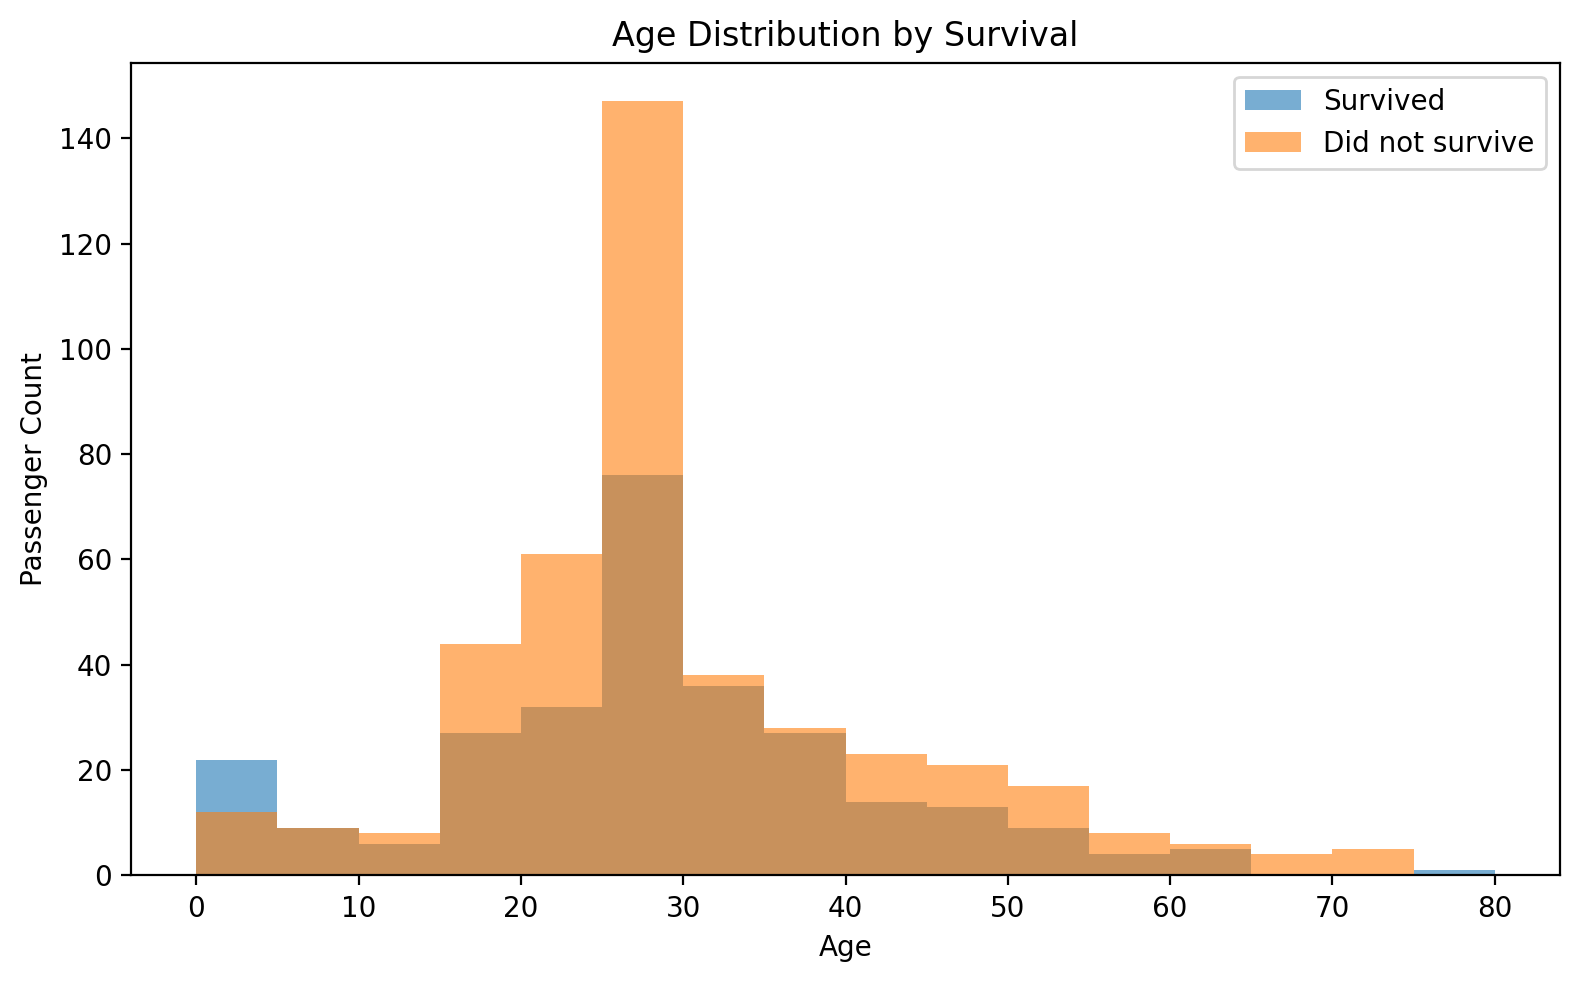

In [4]:
# Keep rows with a known age
age_df = train[["Age", "Survived"]].dropna()

bins = range(0, 81, 5)  # 0–80 in 5-year bins
plt.figure(figsize=(8,5))
plt.hist(age_df[age_df["Survived"] == 1]["Age"], bins=bins, alpha=0.6, label="Survived")
plt.hist(age_df[age_df["Survived"] == 0]["Age"], bins=bins, alpha=0.6, label="Did not survive")
plt.title("Age Distribution by Survival")
plt.xlabel("Age")
plt.ylabel("Passenger Count")
plt.legend()
plt.tight_layout()
plt.show()

## Part 3 - Experiments

In [5]:
# Create FamilySize in both train and test
for df in (train, test):
    df['FamilySize'] = df.get('SibSp', 0) + df.get('Parch', 0) + 1

# Features used
target_col = 'Survived'
num_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
cat_features = ['Sex', 'Embarked']

# Split X/y for training
X_train = train[num_features + cat_features]
y_train = train[target_col]
X_test  = test[num_features + cat_features]

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test  shape:', X_test.shape)

X_train shape: (712, 8)
y_train shape: (712,)
X_test  shape: (179, 8)


In [6]:
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', numeric_pipe, num_features),
    ('cat', categorical_pipe, cat_features)
])

clf = LogisticRegression(max_iter=200, solver='liblinear')
pipe = Pipeline([
    ('preprocess', preprocess),
    ('clf', clf)
])

param_grid = {
    'preprocess__num__scaler': [StandardScaler(), 'passthrough'],
    'clf__C': [0.1, 1.0, 10.0]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=False,
    verbose=1
)

## Part 4 - Training

In [7]:
grid.fit(X_train, y_train)
print('Best params:', grid.best_params_)
print('Best CV F1:', grid.best_score_)

cv_results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
display(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'clf__C': 1.0, 'preprocess__num__scaler': StandardScaler()}
Best CV F1: 0.7338625082055202


,params,mean_test_score,std_test_score,rank_test_score
2,"{'clf__C': 1.0, 'preprocess__num__scaler': Sta...",0.733863,0.014297,1
4,"{'clf__C': 10.0, 'preprocess__num__scaler': St...",0.732573,0.013231,2
5,"{'clf__C': 10.0, 'preprocess__num__scaler': 'p...",0.732573,0.013231,2
3,"{'clf__C': 1.0, 'preprocess__num__scaler': 'pa...",0.729414,0.016841,4
0,"{'clf__C': 0.1, 'preprocess__num__scaler': Sta...",0.726575,0.015732,5
1,"{'clf__C': 0.1, 'preprocess__num__scaler': 'pa...",0.720981,0.019583,6


## Part 5 - Apply on test and show model performance estimation

In [8]:
best_model = grid.best_estimator_
test_pred = best_model.predict(X_test)

out = test.loc[X_test.index].copy()
out['Survived_pred'] = test_pred
display(out.head(5))

y_true = test.loc[X_test.index, 'Survived']
f1_test = f1_score(y_true, test_pred)
print('Test F1:', f1_test)
print('\nClassification report (test):\n')
print(classification_report(y_true, test_pred))

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,FamilySize,Survived_pred
0,3,1,35.000000,0,0,7.0500,0,0,1,0
1,3,1,30.000000,0,0,7.2500,0,0,1,0
2,3,1,29.699118,0,0,14.5000,0,0,1,0
3,3,0,21.000000,0,0,7.7500,2,0,1,1
4,3,1,32.000000,0,0,56.4958,0,1,1,0


Test F1: 0.6890756302521008

Classification report (test):

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       118
           1       0.71      0.67      0.69        61

    accuracy                           0.79       179
   macro avg       0.77      0.76      0.77       179
weighted avg       0.79      0.79      0.79       179

